# **micrograd** autograd engine

In [1]:
import numpy as np

### derivative of a simple function with one input

In [2]:
def f(x):
    return x**2 - 2*x + 1

In [3]:
import numpy as np
xs =  np.arange(start=-5, stop=5, step=0.25)
ys = f(xs)

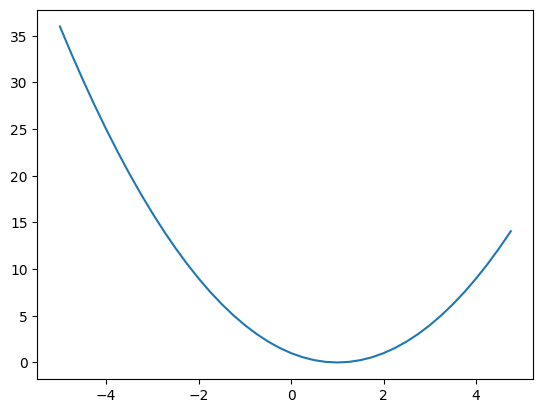

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(xs, ys);

In [5]:
x = 1.0
h = 0.00000001
slope = (f(x+h) - f(x)) / h 
slope

0.0

### derivative of a function with multiple inputs

In [6]:
h = 0.000001
for i in range(3):
    a = [2.0, -3.0, 10.0]
    d1 = a[0]*a[1] + a[2]
    a[i] += h
    d2 = a[0]*a[1] + a[2]
    print(f'slope: {round((d2-d1)/h, 2)}')


slope: -3.0
slope: 2.0
slope: 1.0


### starting the core Value object of micrograd and its visualization

In [7]:
class Value:

    def __init__(self, data, _children=tuple(), _op=str(), label=str()):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        return out

In [8]:
a = Value(1.2)
b = Value(3.4)
c = Value(5.6)

d = a * b + c
d, d._prev, d._op

(Value(data=9.68), {Value(data=4.08), Value(data=5.6)}, '+')